In [1]:
import pandas as pd
from fbprophet import Prophet

# Test Prophet with ICPW data

A very quick test of Facebook's [Prophet](https://facebook.github.io/prophet/) algorithm, as applied to ICPW.

## 1. Get data

Pick a station with long-term monitoring at fairly high frequency. `'CA01'` looks to have multiple samples per month for the full 27 year time period.

In [2]:
# Read data
xl_path = r'../../update_autumn_2018/results/all_chem_1990-2016.xlsx'
df = pd.read_excel(xl_path, sheet_name='data')
df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,ALK-E_µEq/l,Al_µg/l,As_µg/l,COLOUR_,...,Pb_µg/l,Qs_m3/s,SO4_mg/l,SiO2_mg SiO2/l,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,Temp_oC,Zn_µg/l,pH_
0,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-03,0,0,50.5,86.6,NaN,NaN,...,NaN,NaN,5.63,2.01,4.17,352.0,6.1,NaN,8.2,6.95
1,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-09,0,0,50.0,84.0,NaN,NaN,...,NaN,NaN,5.53,2.01,3.94,598.0,5.7,NaN,8.2,6.05
2,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-15,0,0,50.9,81.4,NaN,NaN,...,NaN,NaN,5.47,2.06,3.69,530.0,5.8,NaN,7.3,6.07
3,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-24,0,0,56.6,76.8,NaN,NaN,...,NaN,NaN,5.34,2.05,3.71,493.0,4.7,NaN,8.6,5.93
4,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",1990-01-31,0,0,59.9,124.2,NaN,NaN,...,NaN,NaN,5.64,2.10,3.85,815.0,8.9,NaN,8.9,5.97


In [3]:
# Resample to monthly for CA01
df = df.query('station_id == 38085')
df.index = df['sample_date']
df = df.resample('M').mean().reset_index()
df.head()

,sample_date,station_id,depth1,depth2,ALK-E_µEq/l,Al_µg/l,As_µg/l,COLOUR_,Ca_mg/l,Cd_µg/l,...,Pb_µg/l,Qs_m3/s,SO4_mg/l,SiO2_mg SiO2/l,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,Temp_oC,Zn_µg/l,pH_
0,1990-01-31,38085.0,0.0,0.0,53.580000,90.600000,NaN,NaN,2.894000,NaN,...,NaN,NaN,5.522000,2.046000,3.872000,557.60,6.240000,NaN,8.240000,6.194000
1,1990-02-28,38085.0,0.0,0.0,60.575000,90.250000,NaN,NaN,3.020000,NaN,...,NaN,NaN,5.455000,2.427500,3.720000,658.25,5.225000,NaN,9.075000,5.950000
2,1990-03-31,38085.0,0.0,0.0,38.316667,141.616667,NaN,NaN,2.794167,NaN,...,NaN,NaN,5.216667,3.239167,4.312500,874.00,5.941667,NaN,13.108333,5.633333
3,1990-04-30,38085.0,0.0,0.0,31.511111,153.933333,NaN,NaN,2.633889,NaN,...,NaN,NaN,5.095000,3.514444,4.455556,1166.00,16.580000,NaN,9.705556,5.668889
4,1990-05-31,38085.0,0.0,0.0,41.166667,112.816667,NaN,NaN,2.588333,NaN,...,NaN,NaN,4.896667,2.451667,3.858333,525.50,7.150000,NaN,7.166667,6.226667


## 2. Trends in TOC

In [4]:
# Get TOC
toc_df = df[['sample_date', 'TOC_mg C/l']]
toc_df.columns = ['ds', 'y']
toc_df.head()

,ds,y
0,1990-01-31,3.872000
1,1990-02-28,3.720000
2,1990-03-31,4.312500
3,1990-04-30,4.455556
4,1990-05-31,3.858333


In [5]:
# Fit model
m = Prophet()
m.fit(toc_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


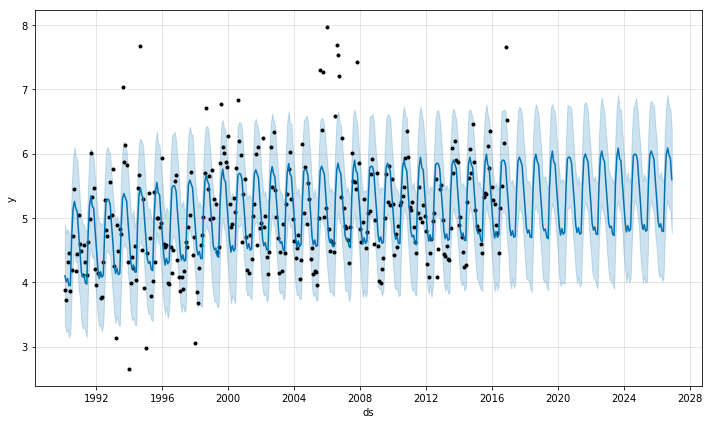

In [6]:
# Predict the next 10 years, with uncertainty
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)

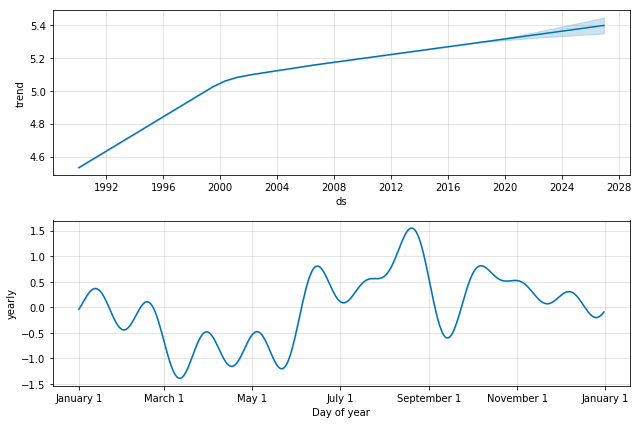

In [7]:
# Explore components
fig = m.plot_components(fcst)

The data suggests that TOC increased rapdily from 1990 to around 2000, and then continued to increase more slowly. The annual component shows that TOC concentrations are genrally a bit higher during the summer.

## 3. Trends in SO4

**Note:** This is just raw SO4 for now (i.e. not corrected in any way).

In [8]:
# Get SO4
so4_df = df[['sample_date', 'SO4_mg/l']]
so4_df.columns = ['ds', 'y']
so4_df.head()

,ds,y
0,1990-01-31,5.522000
1,1990-02-28,5.455000
2,1990-03-31,5.216667
3,1990-04-30,5.095000
4,1990-05-31,4.896667


In [9]:
# Fit model
m = Prophet()
m.fit(so4_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


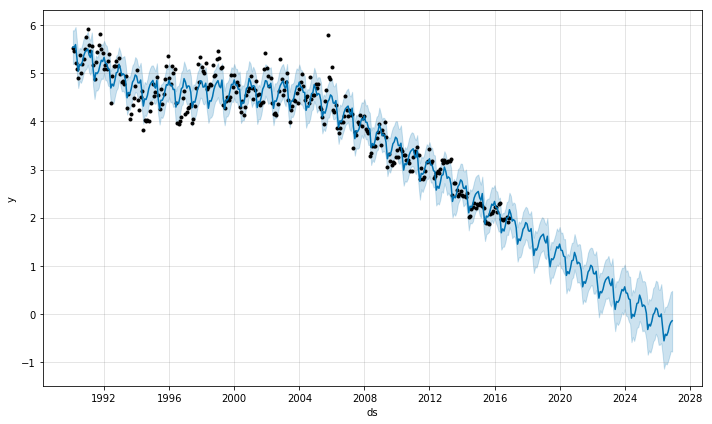

In [10]:
# Predict the next 10 years, with uncertainty
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)

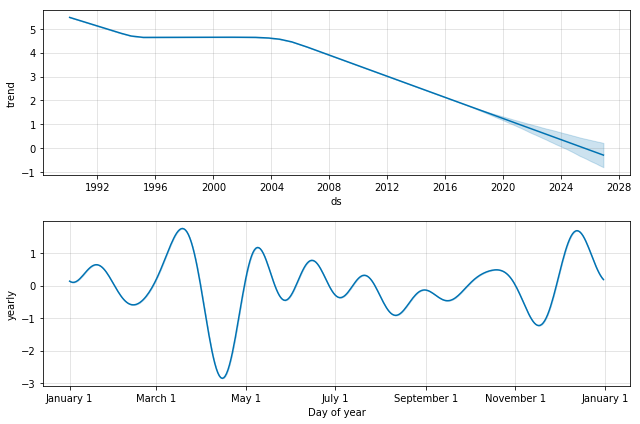

In [11]:
# Explore components
fig = m.plot_components(fcst)

Based on the above plots, SO4 at site `'CA01'`declined rapidly from 1990 to the mid-1990s, then levelled-off until about 2004, then started to decline rapidly again. At the current rate of decrease, SO4 concentrationsare predicted to reach zero by about 2025, although clearly this is an over-extrapolation as the rate of change will slow as the system equilibrates. 